# Classical analysis on radar data

In [1]:
import numpy as np
import scipy.fft
import matplotlib.pyplot as plt

from common import get_experiment_names, load_experiment, declutter

## Declutter experiment

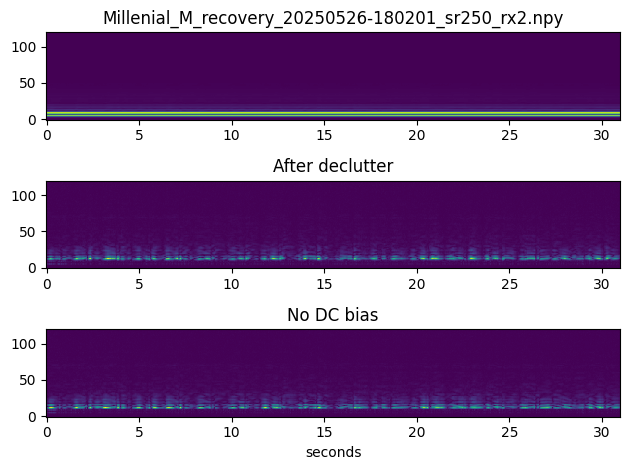

In [2]:
base_folder_path = '../datasets/SR250Mate/recovery'
name = 'Millenial_M_recovery_20250526-180201_sr250_rx2.npy'

raw = load_experiment(base_folder_path, name)
decluttered = declutter(raw)
no_dc_bias = raw - np.mean(raw, axis=0)

bins = np.arange(raw.shape[1])
seconds = np.arange(raw.shape[0]) / 20
XX, YY = np.meshgrid(seconds, bins)

fig, ax = plt.subplots(3,1)
ax[0].pcolormesh(XX, YY, np.abs(raw).T)
ax[0].set_title(name)
ax[1].pcolormesh(XX, YY, np.abs(decluttered).T)
ax[1].set_title('After declutter')
ax[2].pcolormesh(XX, YY, np.abs(no_dc_bias).T)
ax[2].set_title("No DC bias")
ax[2].set_xlabel("seconds")

plt.tight_layout()
plt.show()

## Bin removal
Many bins are absolutely static and show no information. We use the correlation matrix as a tool to investigate dependencies between bins.

In [3]:
base_folder_path, names = get_experiment_names('SR250Mate', 'intensity')

for name in sorted(names):
    print(f"'{name}'")

'MillenIAls_E_100w_low_20250526-160932_sr250_rx0.npy'
'MillenIAls_E_100w_low_20250526-160932_sr250_rx1.npy'
'MillenIAls_E_100w_low_20250526-160932_sr250_rx2.npy'
'MillenIAls_E_100w_low_90rpm_20250526-161135_sr250_rx0.npy'
'MillenIAls_E_100w_low_90rpm_20250526-161135_sr250_rx1.npy'
'MillenIAls_E_100w_low_90rpm_20250526-161135_sr250_rx2.npy'
'MillenIAls_M_100w_low_100rpm_20250526-161943_sr250_rx0.npy'
'MillenIAls_M_100w_low_100rpm_20250526-161943_sr250_rx1.npy'
'MillenIAls_M_100w_low_100rpm_20250526-161943_sr250_rx2.npy'
'MillenIAls_M_100w_low_75rpm_20250526-161802_sr250_rx0.npy'
'MillenIAls_M_100w_low_75rpm_20250526-161802_sr250_rx1.npy'
'MillenIAls_M_100w_low_75rpm_20250526-161802_sr250_rx2.npy'
'MillenIAls_M_150w_medium_70rpm_20250526-161349_sr250_rx0.npy'
'MillenIAls_M_150w_medium_70rpm_20250526-161349_sr250_rx1.npy'
'MillenIAls_M_150w_medium_70rpm_20250526-161349_sr250_rx2.npy'
'MillenIAls_M_150w_medium_80rpm20250526-162203_sr250_rx0.npy'
'MillenIAls_M_150w_medium_80rpm20250526-1622

In [4]:
name = 'MillenIAls_M_200w_high_75rpm_20250526-161541_sr250_rx2.npy'
raw = load_experiment(base_folder_path, name)
mag = np.abs(raw)

S = np.cov(mag, rowvar=False)
corr = np.corrcoef(mag, rowvar=False)

nbins = raw.shape[1]
assert(S.shape[0] == nbins)
assert(corr.shape[0] == nbins)

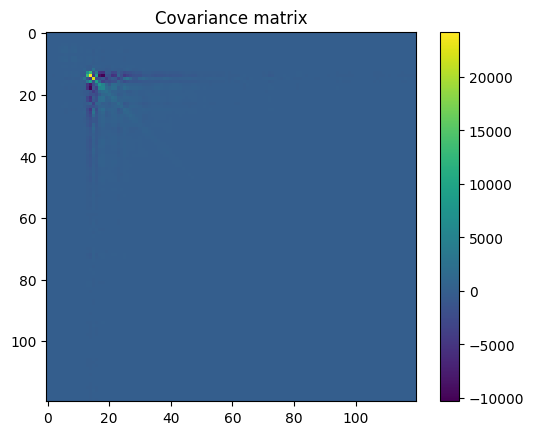

In [5]:
plt.title("Covariance matrix")
plt.imshow(S)
plt.colorbar()
plt.show()

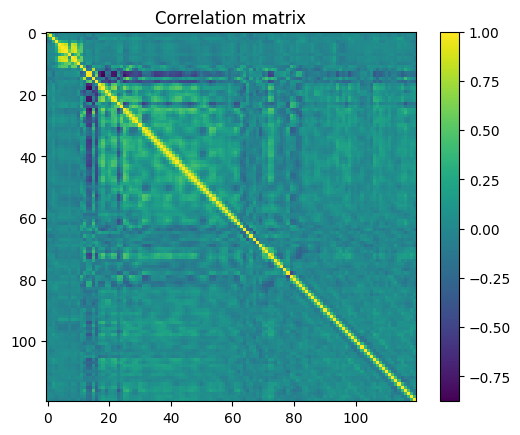

In [6]:
plt.title("Correlation matrix")
plt.imshow(corr)
plt.colorbar()
plt.show()

### Antenna backtalk
I bin dal 4 al 9 sono fortemente correlati tra loro. Questo potrebbe essere collegato al "backtalk" delle antenne, un fenomeno per cui i primi bin della misura non sono utilizzabili. Di seguito un esempio di backtalk

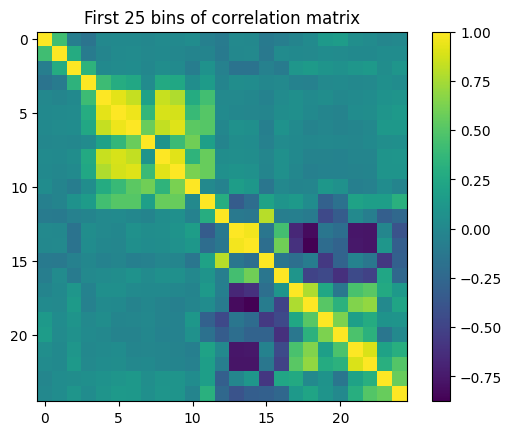

In [7]:
nbins = 25

plt.title(f'First {nbins} bins of correlation matrix')
plt.imshow(corr[:nbins, :nbins])
plt.colorbar()
plt.show()

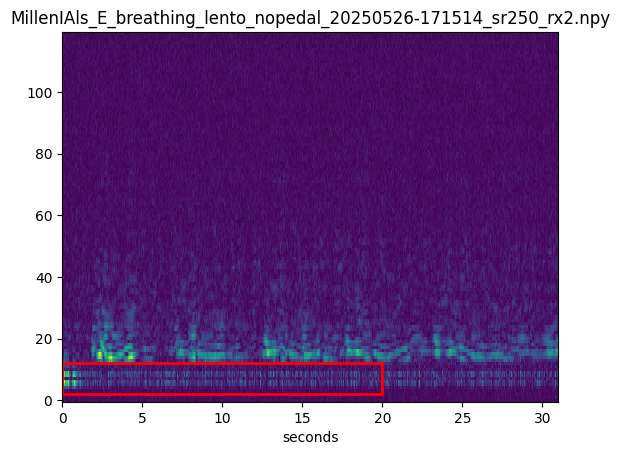

In [8]:
import matplotlib.patches as mpatches

base_folder_path = '../datasets/SR250Mate/breathing'
name = 'MillenIAls_E_breathing_lento_nopedal_20250526-171514_sr250_rx2.npy'

raw = load_experiment(base_folder_path, name)
decluttered = declutter(raw)

plt.title(name)
plt.pcolormesh(XX, YY, np.abs(decluttered).T)
rect = mpatches.Rectangle(xy=(0,2), width=20, height=10, fill=False, color='r', linewidth=2)
plt.gca().add_patch(rect)
plt.xlabel("seconds")
plt.show()

### Analisi sulla varianza intra-bin

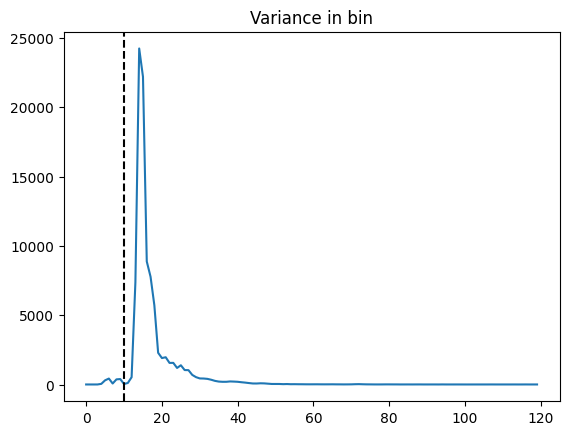

In [9]:
plt.title("Variance in bin")
plt.plot(np.diag(S))
plt.axvline(x=10, c='k', linestyle='dashed')
plt.show()

Va bene, l'analisi sulla varianza ha correttamente eliminato anche i bin che presentano il backtalk delle antenne

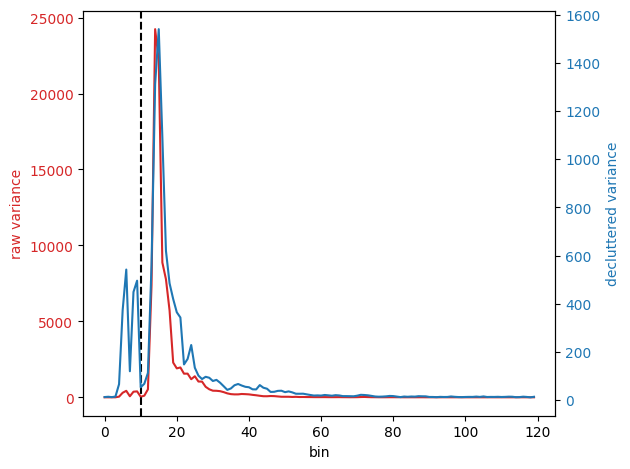

In [10]:
decluttered = declutter(raw)
decluttered_variance = np.var(decluttered, axis=0)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('bin')
ax1.set_ylabel('raw variance', color=color)
ax1.plot(np.diag(S), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(x=10, c='k', linestyle='dashed')

color = 'tab:blue'
ax2 = ax1.twinx()
ax2.set_ylabel('decluttered variance', color=color)
ax2.plot(decluttered_variance, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

### PCA for bin selection
Si considera l'intera timeseries come un dataframe, dove le colonne sono i bin. Si prende la prima componente principale:
  * la score sarà utilizzata per l'analisi dello spettro
  * il loading ci indica la prevalenza dei bin nella combinazione lineare

In [11]:
from sklearn.decomposition import PCA

# PCA on complex data is a delicate problem, let's just use the energy
energy = np.abs(raw)
pca = PCA(n_components=1)
score = pca.fit_transform(energy).reshape(-1)
score = score - np.mean(score, axis=0)
loading = pca.components_.reshape(-1)

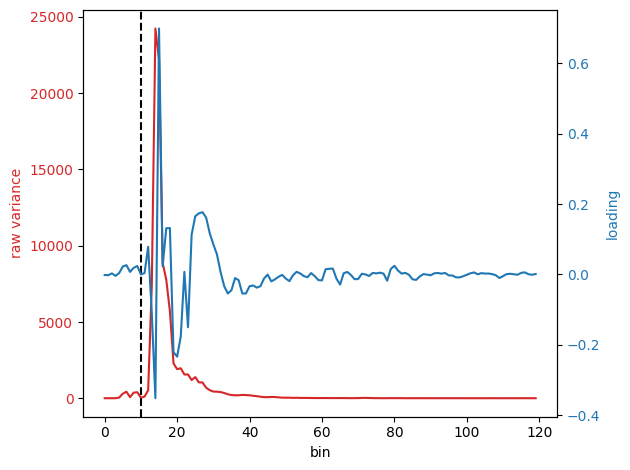

In [12]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('bin')
ax1.set_ylabel('raw variance', color=color)
ax1.plot(np.diag(S), label='bin variance', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axvline(x=10, c='k', linestyle='dashed')

color = 'tab:blue'
ax2 = ax1.twinx()
ax2.set_ylabel('loading', color=color)
ax2.plot(loading, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

La PCA cattura una informazione simile all'analisi della varianza intra-bin, anche se un po' rumorosa.

Ci sono dei bin negativamente correlati, questo lo spiego con il fatto che ciò che abbandona un bin entra nell'altro, quindi i bin vedono l'effetto opposto.

## Analisi della distanza ottimale sensore

In [13]:
subject = 'M'
antenna = 'rx0'
base_folder_path, names = get_experiment_names('SR250Mate', 'signal-to-noise', subject, antenna)

for name in names:
    print(f"'{name}'")

'MillenIAls_M_signal-to-noise_00cm_20250526-150252_sr250_rx0.npy'
'MillenIAls_M_signal-to-noise_60cm_20250526-150705_sr250_rx0.npy'
'MillenIAls_M_signal-to-noise_40cm_20250526-150551_sr250_rx0.npy'
'MillenIAls_M_signal-to-noise_80cm_20250526-150826_sr250_rx0.npy'
'MillenIAls_M_signal-to-noise_20cm_20250526-150449_sr250_rx0.npy'


In [14]:
subset = {}
variances = {}

# inserisco nel dizionario in ordine alfabetico
# per come abbiamo annotato i file, è anche l'ordine crescente di distanza
for name in sorted(names):
    atoms = name.split('_')
    distance = atoms[3]

    raw = load_experiment(base_folder_path, name)
    var = np.var(raw, axis=0)
    
    subset[distance] = name
    variances[distance] = var

for name in subset.values():
    print(name)

MillenIAls_M_signal-to-noise_00cm_20250526-150252_sr250_rx0.npy
MillenIAls_M_signal-to-noise_20cm_20250526-150449_sr250_rx0.npy
MillenIAls_M_signal-to-noise_40cm_20250526-150551_sr250_rx0.npy
MillenIAls_M_signal-to-noise_60cm_20250526-150705_sr250_rx0.npy
MillenIAls_M_signal-to-noise_80cm_20250526-150826_sr250_rx0.npy


In [15]:
# genero una colormap dal rosso al blu per avere un plot più visibile
# le linee vicine sono rosse e gradualmente si spostano verso il blu
cmap = np.linspace(start=[1, 0, 0], stop=[0,0,1], num=len(subset))
cmap

array([[1.  , 0.  , 0.  ],
       [0.75, 0.  , 0.25],
       [0.5 , 0.  , 0.5 ],
       [0.25, 0.  , 0.75],
       [0.  , 0.  , 1.  ]])

In [16]:
distance_to_color_map = {key: val for (key, val) in zip(variances.keys(), cmap)}

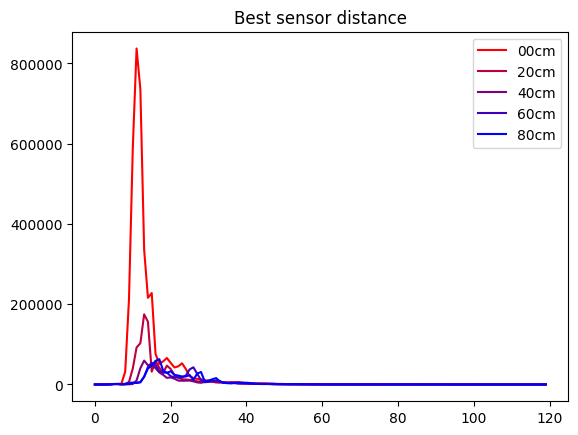

In [17]:
plt.title("Best sensor distance")

for label in variances.keys():
    plt.plot(variances[label], label=label, c=distance_to_color_map[label])

plt.legend()
plt.show()

I picchi di varianza sono molto attenuati. Questo potrebbe essere compatibile con il fatto che la forza del segnale diminuisce con il quadrato della distanza. Intuisco che abbiamo comunque fatto bene a prendere le misure a 20cm.

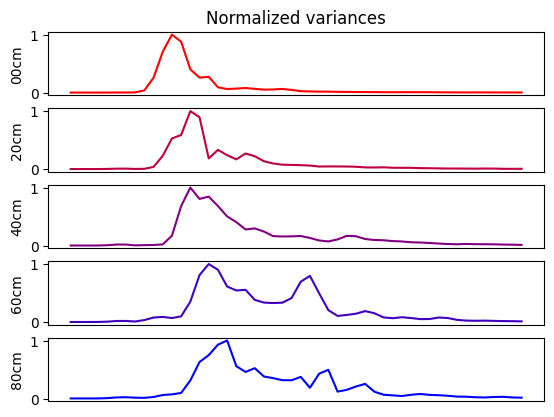

In [18]:
# plot delle varianze, rinormalizzando ai picchi
fig, ax = plt.subplots(len(variances.keys()), 1)

for i, label in enumerate(variances.keys()):
    var = variances[label]
    normalized = var / np.max(var)

    ax[i].plot(normalized[:50], label=label, c=distance_to_color_map[label])
    ax[i].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False)
    ax[i].set_ylabel(label)

ax[0].set_title('Normalized variances')
plt.show()

Per distanze maggiori di 60 centimetri si identificano due picchi. Una spiegazione possibile è che la cyclette e il soggetto siano visti come due entità separate